# Exercise 3 - Neural Networks and Multiclass classification : Handwritten Digit Recognition

You are given a data set in ex3data1.mat that contains 5000 training exam-
ples of handwritten digits.2 The .mat format means that that the data has
been saved in a native Octave/MATLAB matrix format, instead of a text
(ASCII) format like a csv-file

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot as plt

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# define the submission/grader object for this exercise
grader = utils.Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

Note that, each training example is `20 * 20 pixels ` , Each pixel is represented by a floating point number indicating the grayscale intensity of that location.

In [2]:
# reading mat file
mat = loadmat('Data/ex3data1.mat')

# setting up the parameters for the exercise

input_layer_size = 400
hidden_layer_size = 25 
num_labels = 10 # from 0 to 9



In [3]:
X = mat['X']
Y = mat['y']

# set the zero digit to 0, rather than its mapped 10 in this dataset
# This is an artifact due to the fact that this dataset was used in 
# MATLAB where there is no index 0
Y[Y == 10] = 0

In [4]:
X.shape,Y.shape

((5000, 400), (5000, 1))

We can cleary see X reprents a 5000 by 400 matrix:


$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

Every row in the matrix represents a training example .

## <center> =========== Part 1: Loading and Visualizing Data ============= </center>

The function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together, selecting 100 random rows from `X` .

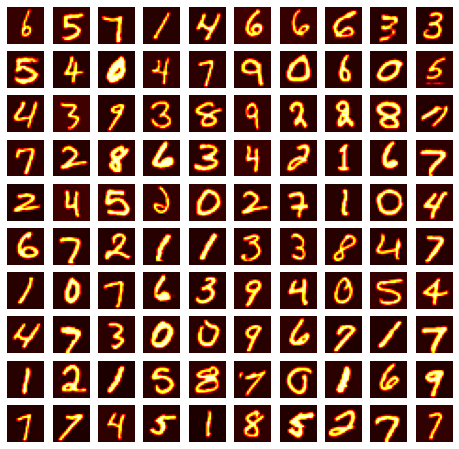

In [5]:
import matplotlib.image as mpimg

fig, axis = plt.subplots(10,10,figsize=(8,8))


for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"), cmap="hot") #reshape back to 20 pixel by 20 pixel
        axis[i,j].axis("off") # (0,5000)

# order = "F" ensures the orientation of the image is upright

# 1.3 Vectorizing Logistic Regression

We will use one-vs-all logistic regression to build a multi-class classifier , In the problem , 10 classes exists , since there are 10 numbers between 0 and 9, it's encouraged to ensure the code is well vectorized , and not employ any `for` loops.

# Vectorizing the cost function

Recall that the (un)regularized logisit regression is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left( h_\theta\left( x^{(i)} \right) \right) - \left(1 - y^{(i)} \right) \log \left(1 - h_\theta \left( x^{(i)} \right) \right) \right] $$


Remember that we have to compute the hypothesis function $h_{\theta}$ on every iteration `i` , where  $h_\theta(x^{(i)}) = \sigma(\theta^T x^{(i)})$ and $\sigma(z) = \frac{1}{1+e^{-z}}$

We can define $X$ and $\theta$ as the following matrices:

$$ X = \begin{bmatrix} - \left( x^{(1)} \right)^T - \\ - \left( x^{(2)} \right)^T - \\ \vdots \\ - \left( x^{(m)} \right)^T - \end{bmatrix} \qquad \text{and} \qquad \theta = \begin{bmatrix} \theta_0 \\ \theta_1 \\ \vdots \\ \theta_n \end{bmatrix} $$

Since $a^{T}b = b^Ta$ when $a^Tb$ is symmetric , we can simply compute the matrix/vector multiplication of $X$ and $\theta$ to obtain part of $h_\theta(x^{(i)})$

$$ X\theta = \begin{bmatrix} - \left( x^{(1)} \right)^T\theta - \\ - \left( x^{(2)} \right)^T\theta - \\ \vdots \\ - \left( x^{(m)} \right)^T\theta - \end{bmatrix} = \begin{bmatrix} - \theta^T x^{(1)}  - \\ - \theta^T x^{(2)} - \\ \vdots \\ - \theta^T x^{(m)}  - \end{bmatrix} $$


We will use this to calculate $\theta^T x^{(i)}$

In [6]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def hypothesis(X,theta):
    return sigmoid(np.dot(X,theta))



## 1.3.2 Vectorizing the gradient

Recalling that the gradient  is defined as:

$$ \frac{\partial J }{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( \left( h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_j^{(i)} \right) $$

To vectorize it , we start by writing the partial derivatives explicitly as follows:



$$
\begin{align*}
\begin{bmatrix} 
\frac{\partial J}{\partial \theta_0} \\
\frac{\partial J}{\partial \theta_1} \\
\frac{\partial J}{\partial \theta_2} \\
\vdots \\
\frac{\partial J}{\partial \theta_n}
\end{bmatrix} = &
\frac{1}{m} \begin{bmatrix}
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_0^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_1^{(i)}\right) \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_2^{(i)}\right) \\
\vdots \\
\sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x_n^{(i)}\right) \\
\end{bmatrix} \\
= & \frac{1}{m} \sum_{i=1}^m \left( \left(h_\theta\left(x^{(i)}\right) - y^{(i)} \right)x^{(i)}\right) \\
= & \frac{1}{m} X^T \left( h_\theta(x) - y\right)
\end{align*}
$$


Where we define $h_\theta - y $ as:

$$  h_\theta(x) - y = 
\begin{bmatrix}
h_\theta\left(x^{(1)}\right) - y^{(1)} \\
h_\theta\left(x^{(2)}\right) - y^{(2)} \\
\vdots \\
h_\theta\left(x^{(m)}\right) - y^{(m)} 
\end{bmatrix} $$

Since $h_\theta - y $ is a scalar , we can better define it as:
observe that:

$$ \sum_i \beta_ix^{(i)} = \begin{bmatrix} 
| & | & & | \\
x^{(1)} & x^{(2)} & \cdots & x^{(m)} \\
| & | & & | 
\end{bmatrix}
\begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_m
\end{bmatrix} = x^T \beta
$$

Where :  $\beta_i = \left( h_\theta(x^{(i)} - y^{(i)} \right)$.

Debug tip : print the sizes with `shape` to verify valid multiplaction between matrices 

## Defining the vectorized version of the regularized logistic regression

We have now definied a vectorized version of unregularized logistic regression 

Note that you should not be regularizing $\theta_0$ which is used for the bias term.
Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$ is defined as

$$
\begin{align*}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \text{for } j  \ge 1
\end{align*}
$$


Now let's code a lrCostFunction without any for loops 

In [7]:
X[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [8]:
def gradientdescent(theta,X,y,lambda_term):

    m = len(y)

    
    Beta = (hypothesis(X,theta) - y)

    gradient = np.zeros(theta.shape)
    gradient = 1/m * np.matmul(np.transpose(X),Beta)
    # computing the vectorized regularized gradient
    gradient[1:] = gradient[1:] + lambda_term/m * theta[1:]

    return gradient.flatten()

    

In [9]:


def lrCostFunction(theta,X,y,lambda_term): 

    m = len(y)

    error_element = y * (np.log(hypothesis(X,theta))) + (1-y) * np.log(1-hypothesis(X,theta))
    
    cost =  np.sum(error_element)/(-m)

    # we add the regularization term to cost  to penalize high values of the parameters
  
    cost = cost + lambda_term/(2*m)*np.sum(np.square(theta[1:])) #skip first element of the array

    # computing the vectorized unregularized gradient

    

    return cost


In [10]:
theta_t = np.array([-2,-1,1,2]).reshape(4,1)
X_t =np.array([np.linspace(0.1,1.5,15)]).reshape(3,5).T
X_t = np.hstack((np.ones((5,1)), X_t))
y_t = np.array([1,0,1,0,1]).reshape(5,1)
J, grad = lrCostFunction(theta_t,X_t,y_t, 3),gradientdescent(theta_t,X_t,y_t, 3)
print("Cost:",J,"Expected cost: 2.534819")
print("Gradients:\n",grad,"\nExpected gradients:\n 0.146561\n -0.548558\n 0.724722\n 1.398003")


Cost: 2.534819396109744 Expected cost: 2.534819
Gradients:
 [ 0.14656137 -0.54855841  0.72472227  1.39800296] 
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


In [11]:
# appends the implemented function in part 1 to the grader object
#grader[1] = lrCostFunction

# send the added functions to coursera grader for getting a grade on this part
#grader.grade()

# One vs all Classification

In [12]:
m, n = X.shape[0], X.shape[1]

In [13]:
ones = np.ones((m,1))

X = np.hstack((ones, X)) #add the intercept
(m,n) = X.shape

<li> 1 vs rest/all or 1 -1 </li>

In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the  𝐾  classes in our dataset. In the handwritten digits dataset,  𝐾=10 , but your code should work for any value of  𝐾 .

In [14]:

import scipy.optimize as opt


def oneVsAll(X, y, num_labels, lambda_term):

    m, n = X.shape[0], X.shape[1]
        
    
    #Since we have 10 different models, we needed to
    # find the optimal parameters for each model by using a for-loop.

    for i in range(num_labels):
        digit_class = i if i else 10
        theta[i] = opt.fmin_cg(f = lrCostFunction, x0 = theta[i],  fprime = gradientdescent, args = (X, (Y == digit_class).flatten(), lmbda), maxiter = 200)





    return theta

In [15]:
lmbda = 0.1
k = 10
theta = np.zeros((k,n)) #inital parameters


In [16]:
lambda_ = 0.1
theta = oneVsAll(X, Y, num_labels, lambda_)

Optimization terminated successfully.
         Current function value: 0.000048
         Iterations: 9
         Function evaluations: 46
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: 0.013121
         Iterations: 118
         Function evaluations: 443
         Gradient evaluations: 443
         Current function value: 0.050833
         Iterations: 200
         Function evaluations: 610
         Gradient evaluations: 610
         Current function value: 0.057625
         Iterations: 200
         Function evaluations: 581
         Gradient evaluations: 581
Optimization terminated successfully.
         Current function value: 0.033081
         Iterations: 173
         Function evaluations: 561
         Gradient evaluations: 561
         Current function value: 0.054511
         Iterations: 200
         Function evaluations: 581
         Gradient evaluations: 581
Optimization terminated successfully.
         Current function valu

In [17]:
pred = np.argmax(X @ theta.T, axis = 1)
pred = [e if e else 10 for e in pred]
np.mean(pred == Y.flatten()) * 100

86.52

In [18]:
pred = np.argmax(X @ theta.T, axis = 1)
pred

array([9, 5, 8, ..., 9, 9, 7])

In [19]:
Y.flatten()

Y_cero = Y[np.where(Y==0)]

In [20]:

np.array(pred).flatten()

array([9, 5, 8, ..., 9, 9, 7])

In [21]:
# predictions for only 0 digits

#pred = np.argmax(X @ theta.T, axis = 1)


#pred = [e if e else 10 for e in pred]


#np.mean(pred_cero == Y_cero) * 100


## Predictions vs Actual Digits

Prediction: 7


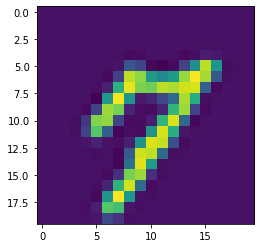

In [22]:
#test the prediction
def predictRandomDigit():
    random_digit = X[np.random.randint(X.shape[0])]
    #remove intercept term for reshape to work
    plt.imshow(random_digit[1:].reshape((20, 20), order='F'))
    predicted = np.argmax(sigmoid(np.dot(random_digit, theta.T)))
    print(f"Prediction: {predicted}")
    
predictRandomDigit()

## Neural Networks

We got a $86.42\%$ accuracy with one vs all logistic regression!  While good , this could be improved , let's try the same thing now with neural networks.

In this part of the exercise, I will implement a neural network to recognize handwritten digits using the same training set as before.

Our goal is to implement the feedforward propagation algorithm to use our weights for prediction.

In the following  secondary notebook, I will attempt to implement the code of a neural network from scratch (No TF)

## [A Neural Net from Scratch](https://link)

## Creating a Neural Network class